# The Second LDA Model: Business & Economics with 13,329 articles

## #1. General information

This is a script that helps you explore the second LDA model. 

It is a part of a Book Chapter "***How can a machine learning-based LDA model help identify relevant literature?***" by A. Akagić & S. Kadić-Maglajlić, published in a book *Handbook of Engaged Marketing Research: How to design for purposeful and impactful research*.

Please follow instructions below.

*Please email the creators of these scripts if you are unable to run them, or have some questions: aakagic@etf.unsa.ba, skm.marktg@cbs.dk.*

## #2. Install necessary packages

In [ ]:
!pip install scikit-learn==0.24.1
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
!pip install pyLDAvis
!pip install gensim

In [ ]:
!pip install pandas --upgrade

In [ ]:
!pip install --upgrade --user nbconvert

## #3. Load packages

In [1]:
import numpy as np 
import pandas as pd
import sys
import os

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import scispacy
import spacy
import en_core_sci_lg

import gensim

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## #4. Load articles (body text)

In [2]:
print('Loading and Preprocessing Data')
filename = 'data/Business_and_Economics_selected_papers.csv'
df = pd.read_csv(filename)
is_covid19_article = df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')

Loading and Preprocessing Data


## #5. Load other important files and functions that will be used later.

In [3]:
# medium model
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 6010000

Load different functions which will be used later. 

In [4]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def get_k_nearest_docs(doc_dist, k=5, lower=1950, upper=2021, only_covid19=False, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
    
    relevant_time = df.publish_year.between(lower, upper)
    
    if only_covid19:
        temp = doc_topic_dist[relevant_time & is_covid19_article]
        
    else:
        temp = doc_topic_dist[relevant_time]
    
         
    distances = temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest
    
def get_k_nearest_docs2(doc_dist, k=5, lower=1950, upper=2021, only_covid19=False, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
    
    relevant_time = df.publish_year.between(lower, upper)
    
    doc_topic_dist2 = doc_topic_dist.iloc[:, 0:20]
        
    if only_covid19:
        temp = doc_topic_dist2[relevant_time & is_covid19_article]
        
    else:
        temp = doc_topic_dist2[relevant_time]
         
    distances = temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest

def plot_article_dna(paper_id, width=20):
    t = df[df.paper_id == paper_id].title.values[0]
    doc_topic_dist[df.paper_id == paper_id].T.plot(kind='bar', legend=None, title=t, figsize=(width, 4))
    plt.xlabel('Topic')

def compare_dnas(paper_id, recommendation_id, width=20):
    t = df[df.paper_id == recommendation_id].title.values[0]
    temp = doc_topic_dist[df.paper_id == paper_id]
    ymax = temp.max(axis=1).values[0]*1.25
    temp = pd.concat([temp, doc_topic_dist[df.paper_id == recommendation_id]])
    temp.T.plot(kind='bar', title=t, figsize=(width, 4), ylim= [0, ymax])
    plt.xlabel('Topic')
    plt.legend(['Selection', 'Recommendation'])

# compare_dnas('90b5ecf991032f3918ad43b252e17d1171b4ea63', 'a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a')

def dna_tabs(paper_ids):
    k = len(paper_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = plot_article_dna(paper_ids[i])
            plt.show(ax)

def compare_tabs(paper_id, recommendation_ids):
    k = len(recommendation_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = compare_dnas(paper_id, recommendation_ids[i])
            plt.show(ax)

def recommendation(paper_id, k=5, lower=1950, upper=2021, only_covid19=False, plot_dna=False):
    '''
    Returns the title of the k papers that are closest (topic-wise) to the paper given by paper_id.
    '''
    print(df.title[df.paper_id == paper_id].values[0])

    recommended, dist = get_k_nearest_docs(doc_topic_dist[df.paper_id == paper_id].iloc[0], k, lower, upper, only_covid19, get_dist=True)
    recommended = df.iloc[recommended].copy()
    recommended['similarity'] = 1 - dist 
    
    h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' +' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in recommended[['url','title', 'similarity']].values])
    display(HTML(h))
    
    if plot_dna:
        compare_tabs(paper_id, recommended.paper_id.values)

def info_about_paper(paper_id):
    '''
    Returns the most important data about the paper.
    '''
    
    h = '<br/> <strong>Title</strong>: <a href="' + str(df.url[df.paper_id == paper_id].values[0]) + '" target="_blank">' + str(df.title[df.paper_id == paper_id].values[0]) + '</a> <br/> <strong>Authors</strong>: ' + str(df.authors[df.paper_id == paper_id].values[0]) + '<br/> <strong>Journal</strong>: ' + str(df.journal[df.paper_id == paper_id].values[0]) + '<br/> <strong>Publish time</strong>: ' + str(df.publish_time[df.paper_id == paper_id].values[0]) + '<br/> <strong>Abstract</strong>: ' + str(df.abstract[df.paper_id == paper_id].values[0]) + '<br/> <strong>Body text</strong>: ' + str(df.body_text[df.paper_id == paper_id].values[0]) + ''
    display(HTML(h))

def related_papers():
    '''
    Creates a widget where you can select one of many papers about covid-19 and then displays related articles from the whole dataset.
    '''
    covid_papers = df[df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')][['paper_id', 'title']] # are there more names?
    title_to_id = covid_papers.set_index('title')['paper_id'].to_dict()
    
    def main_function(bullet, k=5, year_range=[1950, 2021], only_covid19=False):
        recommendation(title_to_id[bullet], k, lower=year_range[0], upper=year_range[1], only_covid19=only_covid19)
    
    yearW = widgets.IntRangeSlider(min=1950, max=2021, value=[2010, 2021], description='Year Range', 
                                   continuous_update=False, layout=Layout(width='40%'))
    covidW = widgets.Checkbox(value=False,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='20%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='20%'))

    bulletW = widgets.Select(options=title_to_id.keys(), layout=Layout(width='90%', height='200px'), description='Title:')

    widget = widgets.interactive(main_function, bullet=bulletW, k=kWidget, year_range=yearW, only_covid19=covidW)

    controls = VBox([Box(children=[widget.children[:-1][1], widget.children[:-1][2], widget.children[:-1][3]], 
                         layout=Layout(justify_content='space-around')), widget.children[:-1][0]])
    output = widget.children[-1]
    display(VBox([controls, output]))

def relevant_articles(tasks, k=3, lower=1950, upper=2021, only_covid19=False):
    tasks = [tasks]
    
    tasks_vectorized = vectorizer.transform(tasks)
    tasks_topic_dist = pd.DataFrame(lda.transform(tasks_vectorized))
    
    for index, bullet in enumerate(tasks):
        print(bullet)
        recommended, dist = get_k_nearest_docs2(tasks_topic_dist.iloc[index], k, lower, upper, only_covid19, get_dist=True)
        recommended = df.iloc[recommended].copy()
        recommended['similarity'] = 1 - dist 

        #h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' for l, n in recommended[['url','title']].values])
        #display(HTML(h))
        h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' +' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in recommended[['url','title', 'similarity']].values])
        display(HTML(h))

def relevant_articles_for_text():    
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='200px')
    )

    yearW = widgets.IntRangeSlider(min=1950, max=2021, value=[2010, 2021], description='Year Range', 
                               continuous_update=False, layout=Layout(width='40%'))
    covidW = widgets.Checkbox(value=True,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='25%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='25%'))

    button = widgets.Button(description="Search")

    display(VBox([HBox([kWidget, yearW, covidW], layout=Layout(width='90%', justify_content='space-around')),
        textW, button], layout=Layout(align_items='center')))

    def on_button_clicked(b):
        clear_output()
        display(VBox([HBox([kWidget, yearW, covidW], layout=Layout(width='90%', justify_content='space-around')),
            textW, button], layout=Layout(align_items='center')))        
        relevant_articles(textW.value, kWidget.value, yearW.value[0], yearW.value[1], covidW.value)

    button.on_click(on_button_clicked)

is_covid19_article = df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')

In [5]:
vectorizer = joblib.load('model_economics/vectorizer.csv')
lda = joblib.load('model_economics/lda.csv')
data_vectorized = joblib.load('model_economics/data_vectorized.csv')
doc_topic_dist = pd.read_csv('model_economics/doc_topic_dist.csv')

## #6. Explore the text corpus from CSV file.

### #6.1 How many papers are in the text corpus?

In [6]:
# Number of papers
print("The number of papers in the csv file is: " + str(len(df)))

The number of papers in the csv file is: 13329


### #6.2 Get the paper ID of the row #:

In [7]:
df.iloc[200].paper_id

'03d05413ecb3b0ee5d1c5194187708621b93326a'

### #6.3 Print all information about a paper:

In [8]:
info_about_paper('03d05413ecb3b0ee5d1c5194187708621b93326a')

Same as previous, but here we use row ID:

In [9]:
info_about_paper(df.iloc[200].paper_id)

### #6.4 Information about the dataframe structure. Here you can see number of columns and their description, as well as number of Non-null rows.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13329 entries, 0 to 13328
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   paper_id          13329 non-null  object 
 1   body_text         13329 non-null  object 
 2   methods           4887 non-null   object 
 3   results           3736 non-null   object 
 4   source            12545 non-null  object 
 5   title             12545 non-null  object 
 6   doi               11853 non-null  object 
 7   abstract          11650 non-null  object 
 8   publish_time      12545 non-null  object 
 9   authors           12446 non-null  object 
 10  journal           11132 non-null  object 
 11  mag_id            0 non-null      float64
 12  who_covidence_id  0 non-null      float64
 13  arxiv_id          763 non-null    float64
 14  pdf_json_files    12545 non-null  object 
 15  pmc_json_files    10223 non-null  object 
 16  url               12545 non-null  object

In [11]:
all_paper_ids = df.paper_id

In [12]:
all_paper_ids.iloc[:200]

0      000525b51f78000644865b63d47ac27c624c5981
1      0005580cbb4ab0815ae83936686c58a32fe584dc
2      0020de7d33a415f6586dd8d01bd661d7bafb7ed6
3      00214dcf63861d0cec772012d429e76d2830bafe
4      002565bdaa51559e73ac92eaf8e187dfd1111140
                         ...                   
195    03bb1c4a2530a38824cc39de4f02d31b6387ee4d
196    03bbc3d3e6c6fa8ef956b13f44f58714fcfbb694
197    03bbc9c9a79d0ab15c4557939979121fe2ee12cf
198    03c437cb7755d7d5d8bb02286ce0776b8a2b1b0a
199    03c88a83902fa05bce6aa26c9bd26887f8fc4859
Name: paper_id, Length: 200, dtype: object

### #6.5 Example of first 10 rows in the dataframe.

In [13]:
df.head()

,paper_id,body_text,methods,results,source,title,doi,abstract,publish_time,authors,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,publish_year,is_covid19,study_design
0,000525b51f78000644865b63d47ac27c624c5981,Today the term “pandemic” is both a metaphor f...,NaN,NaN,Elsevier; Medline; PMC,Editorial: Root causes and policy dilemmas of ...,10.1016/j.ijdrr.2020.101892,NaN,2020-09-23,"Alcántara-Ayala, Irasema; Burton, Ian; Lavell,...",...,NaN,NaN,NaN,document_parses/pdf_json/000525b51f78000644865...,document_parses/pmc_json/PMC7511160.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32995255/;...,221865617.0,2020,True,[]
1,0005580cbb4ab0815ae83936686c58a32fe584dc,Fulfilling the increase in the supply of cold-...,The conceptual map describes the studied area ...,The questionnaire's data were obtained from 30...,PMC; WHO,The Effect of Traceability System and Manageri...,10.1007/s40171-021-00281-x,This study aims to determine the effect of man...,2021-08-03,"Masudin, Ilyas; Ramadhani, Anggi; Restuputri, ...",...,NaN,NaN,NaN,document_parses/pdf_json/0005580cbb4ab0815ae83...,document_parses/pmc_json/PMC8328815.xml.json,https://doi.org/10.1007/s40171-021-00281-x,236913463.0,2021,True,"['protocol', 'power', 'p-value', 'frequency']"
2,0020de7d33a415f6586dd8d01bd661d7bafb7ed6,"eat and move about freely, making the poor in ...",NaN,NaN,Medline; PMC,"COVID‐19, Boko Haram and the Pursuit of Surviv...",10.1111/ciso.12307,NaN,2020-06-10,"Agbiboa, Daniel E.",...,NaN,NaN,NaN,document_parses/pdf_json/0020de7d33a415f6586dd...,NaN,https://doi.org/10.1111/ciso.12307; https://ww...,219799984.0,2020,True,[]
3,00214dcf63861d0cec772012d429e76d2830bafe,"In the last decade in Italy, public administra...",The static analysis phase of the sponsorship i...,NaN,PMC,The Estimation of the Optimal Level of Product...,10.1007/978-3-030-58814-4_20,The paper explores the theme of sponsorship ai...,2020-08-26,"Dolores, Luigi; Macchiaroli, Maria; De Mare, G...",...,NaN,NaN,NaN,document_parses/pdf_json/00214dcf63861d0cec772...,document_parses/pmc_json/PMC7974347.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,2020,False,"['β', 'estimation']"
4,002565bdaa51559e73ac92eaf8e187dfd1111140,"In response to the COVID‐19 pandemic, social i...",This preliminary research report combines acti...,NaN,PMC,"Negotiated Sharing of Pandemic Data, Models, a...",10.1111/nejo.12340,Urgent responses to the COVID‐19 pandemic depe...,2020-10-01,"Cutcher‐Gershenfeld, Joel; Baker, Karen S.; Be...",...,NaN,NaN,NaN,document_parses/pdf_json/002565bdaa51559e73ac9...,document_parses/pmc_json/PMC7537168.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,2020,True,"['protocol', 'CONSORT']"


Some titles are missing, but we can still access the article through the link!

## #7. Graphical representation of an LDA model

You can change λ in the top right corner if you would like to tweak words distributions in a topic. Values of λ that are very close to 0 will show terms that are more specific for a chosen topic. Meaning that terms that are important for that specific topic will be displayed, but they may not be necessarily important for the whole corpus.

Values of λ that are very close to 1 will show those terms that have the highest ratio between frequency of the terms for that specific topic and the overall frequency of the terms from the corpus. 

For example, change λ to 0.5 to show terms that are more specific for a topic, a not for the whole corpus.

In [14]:
import IPython
IPython.display.HTML(filename='model_economics/lda.html')

## #8. Print selected number of words for each topic. 

Change "n_top_words" to select number of words.

In [15]:
print_top_words(lda, vectorizer, n_top_words=20)


Topic #0: water species human areas climate disease environmental land wildlife risk

Topic #1: financial bank banks market debt capital crisis policy risk credit

Topic #2: risk information social knowledge science disaster process policy scientific ai

Topic #3: network time model smart urban proposed blockchain city information service

Topic #4: model economic growth variables emissions rate income level demand increase

Topic #5: business firms online customers social consumers companies firm customer service

Topic #6: tourism industry innovation development management tourists performance social tourist resilience

Topic #7: market stock covid-19 markets returns price volatility financial oil period

Topic #8: vehicle vehicles technology robots manufacturing time space design car satellite

Topic #9: food energy production consumption waste agricultural electricity demand farmers supply

Topic #10: information digital technology security users technologies services user process

## #9. Identify a dominant topic in each paper

### #9.1 Determine a dominant topic for each paper.

In [16]:
# Get dominant topic for each document
dominant_topic = np.argmax(doc_topic_dist.values, axis=1)
doc_topic_dist['dominant_topic'] = dominant_topic

### #9.2 Select only papers that belong to a specific topic ID. 

**Please note that under `topic_id` you have to specify number which is reduced by 1 from topic id presented in the visualization.**

In [17]:
topic_id = 13
test = doc_topic_dist.apply(lambda x : True
            if x['dominant_topic'] == topic_id else False, axis = 1)
new_dataframe = df.loc[doc_topic_dist[test == True].index]

### #9.3 How many papers belong to this topic?

In [18]:
len(new_dataframe)

322

### #9.4 List the first five papers that belong to this topic.

If you want more topics than modify the command in this was:

`new_dataframe.head(10)`

where 10 represents the number of papers.


In [19]:
new_dataframe.head(10)

,paper_id,body_text,methods,results,source,title,doi,abstract,publish_time,authors,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,publish_year,is_covid19,study_design
7,002d3b735582ee9f1df5abc16bc6aa271f196409,"Pollution, uncleanness, contamination, taboo, ...",Innovation policy on new technology adoption i...,NaN,NaN,NaN,NaN,This paper examines the development of innovat...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,False,"['power', 'association']"
34,00c18ecba42a80eef6126ca0aa89266819f2f2d0,"In 2018, the European Commission launched its ...",NaN,NaN,PMC,Fake reviews on online platforms: perspectives...,10.1007/s43545-021-00193-8,User-generated online reviews have become esse...,2021-07-21,"Martínez Otero, Juan María",...,NaN,NaN,NaN,document_parses/pdf_json/00c18ecba42a80eef6126...,document_parses/pmc_json/PMC8294234.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,NaN,2021,True,[]
115,025339bfce1cb8efa81c5accdabefe04dcdac9d2,The management of infectious diseases in an in...,NaN,NaN,PMC,Managing emerging infectious diseases: Is a fe...,10.1186/1743-8462-1-7,In the 1980's and 1990's HIV/AIDS was the emer...,2004-11-19,"Howse, Genevieve",...,NaN,NaN,NaN,document_parses/pdf_json/025339bfce1cb8efa81c5...,document_parses/pmc_json/PMC544965.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2004,False,['power']
143,02d664f12a3440962a4dbafa72aaa4a319478da6,It is now commonplace to classify the legal pr...,NaN,NaN,PMC,The instruments of Eurozone fiscal surveillanc...,10.1057/s41261-021-00161-5,The past decade has profoundly reshaped the fi...,2021-06-19,"Dermine, Paul",...,NaN,NaN,NaN,document_parses/pdf_json/02d664f12a3440962a4db...,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,NaN,2021,False,['surveillance']
144,02dc27e08922dc95ae8724fadc75f79fd1212b4a,The first challenge to the ODR development is ...,NaN,NaN,PMC,Conclusion,10.1007/978-3-030-54120-0_7,This chapter offers a synopsis of major findin...,2020-10-03,"Zheng, Jie",...,NaN,NaN,NaN,document_parses/pdf_json/02dc27e08922dc95ae872...,document_parses/pmc_json/PMC7972738.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,2020,False,[]
225,0431904e18f153c91f1582d313cd7d627874d2d3,The Annuaire français de droit international w...,NaN,NaN,PMC,Annuaire Français de Droit International,10.1007/978-94-6265-403-7_13,"The Annuaire Français de Droit International, ...",2020-08-08,"Forteau, Mathias",...,NaN,NaN,NaN,document_parses/pdf_json/0431904e18f153c91f158...,document_parses/pmc_json/PMC7978564.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,2020,True,[]
295,0555a67c1f14b4c712fee94cb29d6b97d349179c,Unmanned Aircraft [UA] is a pilotless aircraft...,NaN,NaN,PMC,Aviation and Intervention,10.1007/978-3-319-17022-0_2,"In October 2013, CNN reported that 400 civilia...",2015-02-28,"Abeyratne, Ruwantissa",...,NaN,NaN,NaN,document_parses/pdf_json/0555a67c1f14b4c712fee...,document_parses/pmc_json/PMC7123278.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,2015,False,[]
317,05b9e1cfa4a46c9d01e802c0793c02cf5b8f79bc,The COVID-19 pandemic has been and remains an ...,NaN,NaN,PMC; WHO,Consequences of crisis and the great re-think:...,10.1093/jwelb/jwab015,The COVID-19 pandemic and its resulting disrup...,2021-04-10,"Duggal, Kabir; Rangachari, Rekha; Gupta, Kanika",...,NaN,NaN,NaN,document_parses/pdf_json/05b9e1cfa4a46c9d01e80...,NaN,https://doi.org/10.1093/jwelb/jwab015,233716421.0,2021,True,[]
419,079fe4563819940275613b94feaa95341f7ec4d8,"To deal with these obstacles, health-related n...",NaN,NaN,PMC,Managing the Negotiation Process,10.1007/978-94-007-2780-9_3,"In global public health negotiations, the stak...",2011-10-15,"Fairman, David; Chigas, Diana; McClintock, Eli...",...,NaN,NaN,NaN,document_parses/pdf_json/079fe4563819940275613...,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,2011,False,[]
499,08f670c2b38109fe36cb52335eb0db2e46c3a87b,The control of working time is vital for emplo.

### #9.5 Get more information about the paper.

In [20]:
info_about_paper('04554f62b923b13e1971a50a6308f316abcd49d4')

## #10. Identify dominant papers in each topic

Enter the number of topic identified in #8. An example is provided in the image below. Here, you can enter for example 7, 8, 9, 10, or any topic that you are interested in. **Please note that topic id in #7. and #8. are different, so we recommend using topic id from #8.**

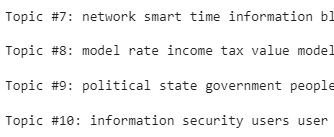

In [21]:
topic_id = 15

In [22]:
new_df = doc_topic_dist.loc[doc_topic_dist['dominant_topic'] == topic_id]

In [24]:
new_df.sort_values(by=[str(topic_id)], ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,dominant_topic
3515,0.000201,0.000201,0.000201,0.000201,0.000201,0.000201,0.000201,0.000201,0.000201,0.000201,...,0.000201,0.000201,0.000201,0.000201,0.996185,0.000201,0.000201,0.000201,0.000201,15
13056,0.000024,0.000024,0.008521,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,...,0.000024,0.000024,0.000024,0.052602,0.938462,0.000024,0.000024,0.000024,0.000024,15
12971,0.032329,0.000059,0.031592,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,...,0.000059,0.000059,0.000059,0.000059,0.935076,0.000059,0.000059,0.000059,0.000059,15
9187,0.000035,0.054172,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,...,0.006691,0.000035,0.000035,0.012122,0.926460,0.000035,0.000035,0.000035,0.000035,15
3014,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943,...,0.060762,0.000943,0.000943,0.000943,0.922257,0.000943,0.000943,0.000943,0.000943,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10118,0.000038,0.197391,0.096385,0.142630,0.075293,0.019875,0.194309,0.020951,0.000038,0.000038,...,0.000038,0.000038,0.000038,0.000038,0.198587,0.000038,0.000038,0.000038,0.011844,15
4868,0.116822,0.000024,0.018219,0.017938,0.000024,0.000024,0.078743,0.035615,0.061646,0.149641,...,0.000024,0.059884,0.017200,0.025029,0.195277,0.000024,0.000024,0.172283,0.000024,15
5412,0.000014,0.004936,0.147852,0.000014,0.000014,0.006618,0.080536,0.000014,0.000014,0.124539,...,0.003514,0.000014,0.054513,0.000014,0.193740,0.185568,0.185070,0.000014,0.003041,15
2834,0.000012,0.102503,0.172075,0.000012,0.000012,0.000012,0.001924,0.000012,0.000012,0.000012,...,0.112049,0.098886,0.078030,0.000012,0.181887,0.090752,0.000012,0.000012,0.161763,15


List the first five papers that are most relevant in the topic. An example output is shown in the figure below. In the next cell enter any of these number, e.g. 3, 13, 47, 104, 119.

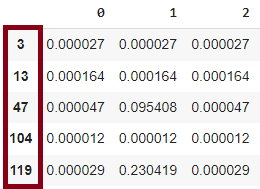

Change `number_of_articles` if you want more papers.

In [25]:
number_of_articles = 10

In [26]:
new_df.sort_values(by=[str(topic_id)], ascending=False)[str(topic_id)].head(number_of_articles)

3515     0.996185
13056    0.938462
12971    0.935076
9187     0.926460
3014     0.922257
13001    0.918191
9505     0.916440
8555     0.913636
13062    0.913225
6168     0.906057
Name: 15, dtype: float64

Once you identify papers, use the first number in the row to identify the paper ID. 

In [27]:
info_about_paper(df.iloc[2515].paper_id)

In [29]:
df.iloc[2515]

paper_id                     2ef6e1486fb5efd078e84850b69a64f7565f57f3
body_text           Nil for this study. George Siopis is a recipie...
methods                                                           NaN
results                                                           NaN
source                                         Elsevier; Medline; PMC
title               The case for promoting physical activity amids...
doi                                       10.1016/j.jsams.2020.11.019
abstract            The coronavirus disease-2019 (COVID-19) pandem...
publish_time                                               2020-12-02
authors                                                Siopis, George
journal                                               J Sci Med Sport
mag_id                                                            NaN
who_covidence_id                                                  NaN
arxiv_id                                                          NaN
pdf_json_files      

## #11. Get recommendation about similar papers. 

Enter the paper ID in the first field, and different number of papers in "k=x". 5 is the default number of papers.

In [30]:
recommendation('03c88a83902fa05bce6aa26c9bd26887f8fc4859', k=5, plot_dna=True)

An Elucidative Review to Analytically Sieve the Viability of Nanomedicine Market


## #12. Different approach for getting recommendations

This is a list of papers in the text corpus presented with a title. When you click on the title, you will get a recommendation about similar papers.

In [31]:
related_papers()

## #13. Map your text into the LDA space and get recommendation about similar papers

**You can try the following text:**
Although the relationship between IT use and salesperson performance remains primarily unsubstantiated, many organizations spend considerable human and financial resources in equipping their sales forces with IT. The cost of automating a sales force can be upwards of $3,500 per salesperson (Girard 1998), and more than 60% of all SFA projects have been unsuccessful (Rivers and Dart 1999). Meanwhile, companies continue to invest in SFA technology in the hopes that improving the speed and quality of information flow among the salespersons will ultimately deliver dividends (Speier and Venkatesh 2002). Marketing and information systems (IS) researchers alike have called for more research in the area of technology use and its impact on salesperson performance (Leigh and Marshall 2001, Marshall et al. 1999) and organizational performance generally (Venkatesh 2006).



In [32]:
relevant_articles_for_text()

Although the relationship between IT use and salesperson performance remains primarily unsubstantiated, many organizations spend considerable human and financial resources in equipping their sales forces with IT. The cost of automating a sales force can be upwards of $3,500 per salesperson (Girard 1998), and more than 60% of all SFA projects have been unsuccessful (Rivers and Dart 1999). Meanwhile, companies continue to invest in SFA technology in the hopes that improving the speed and quality of information flow among the salespersons will ultimately deliver dividends (Speier and Venkatesh 2002). Marketing and information systems (IS) researchers alike have called for more research in the area of technology use and its impact on salesperson performance (Leigh and Marshall 2001, Marshall et al. 1999) and organizational performance generally (Venkatesh 2006).
